In [1]:
from transformers import GPT2LMHeadModel

In [2]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
sd_hf = model_hf.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [ ]:
sd_hf["transformer.wpe.weight"].view(-1)[:20]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

In [ ]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 150])
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])
plt.plot(sd_hf["transformer.wpe.weight"][:, 250])

In [ ]:
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300,:300], cmap="gray")

In [ ]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)


In [ ]:
# let's instead sample manually
import torch
from torch.nn import functional as F

model = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
model.eval()
model.to('cuda')
torch.manual_seed(42)
torch.cuda.manual_seed(42)
tokens = [15496, 11, 314, 1101, 257, 3303, 2746, 11] # "Hello, I'm a language model,"
tokens = torch.tensor(tokens, dtype=torch.long) # (8,)
tokens = tokens.unsqueeze(0).repeat(5, 1) # (5, 8)
x = tokens.to('cuda')

# generate!
while x.size(1) < 30: # max_length=30
    # forward the model to get the logits
    with torch.no_grad():
        logits = model(x)[0] # (B, T, vocab_size)
        # take the logits at the last position
        logits = logits[:, -1, :] # (B, vocab_size)
        # get the probabilities
        probs = F.softmax(logits, dim=-1)
        # do top-k sampling of 50 (huggingface pipeline default)
        # topk_probs here becomes (5, 50), topk_indices is (5, 50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        # note: multinomial does not demand the input to sum to 1
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        # append to the sequence
        x = torch.cat((x, xcol), dim=1)

# print the generated text
import tiktoken
enc = tiktoken.get_encoding('gpt2')
for i in range(5):
    tokens = x[i, :30].tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)

In [ ]:
# tiny shakespeare dataset
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r') as f:
    text = f.read()
data = text[:1000] # first 1,000 characters
print(data[:100])

In [ ]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(data)
print(tokens[:24])

In [ ]:
import torch
buf = torch.tensor(tokens[:24 + 1])
x = buf[:-1].view(4, 6)
y = buf[1:].view(4, 6)
print(x)
print(y)

In [ ]:
print(sd_hf["lm_head.weight"].shape)
print(sd_hf["transformer.wte.weight"].shape)

In [ ]:
(sd_hf["lm_head.weight"] == sd_hf["transformer.wte.weight"]).all()

In [ ]:
print(sd_hf["lm_head.weight"].data_ptr())
print(sd_hf["transformer.wte.weight"].data_ptr())

In [ ]:

# standard deviation grows inside the residual stream
x = torch.zeros(768)
n = 100 # e.g. 100 layers
for i in range(n):
    x += n**-0.5 * torch.randn(768)

print(x.std())

In [1]:
import torch

# super simple little MLP
net = torch.nn.Sequential(
    torch.nn.Linear(16, 32),
    torch.nn.GELU(),
    torch.nn.Linear(32, 1)
)
torch.random.manual_seed(42)
x = torch.randn(4, 16)
y = torch.randn(4, 1)
net.zero_grad()
yhat = net(x)
loss = torch.nn.functional.mse_loss(yhat, y)
loss.backward()
print(net[0].weight.grad.view(-1)[:10])

# the loss objective here is (due to readuction='mean')
# L = 1/4 * [
#            (y[0] - yhat[0])**2 +
#            (y[1] - yhat[1])**2 +
#            (y[2] - yhat[2])**2 +
#            (y[3] - yhat[3])**2
#           ]
# NOTE: 1/4!

tensor([-0.1694, -0.1044, -0.0037,  0.1483, -0.0090,  0.0520, -0.0467, -0.1234,
        -0.2225,  0.0657])


In [ ]:
# now let's do it with grad_accum_steps of 4, and B=1
# the loss objective here is different because
# accumulation in gradient <---> SUM in loss
# i.e. we instead get:
# L0 = 1/4(y[0] - yhat[0])**2
# L1 = 1/4(y[1] - yhat[1])**2
# L2 = 1/4(y[2] - yhat[2])**2
# L3 = 1/4(y[3] - yhat[3])**2
# L = L0 + L1 + L2 + L3
# NOTE: the "normalizer" of 1/4 is lost
net.zero_grad()
for i in range(4):
    yhat = net(x[i])
    loss = torch.nn.functional.mse_loss(yhat, y[i])
    loss = loss / 4 # <-- have to add back the "normalizer"!
    loss.backward()
print(net[0].weight.grad.view(-1)[:10])


Min Train Loss (base): 3.28300905
Min Train Loss (tests): 7.61897469


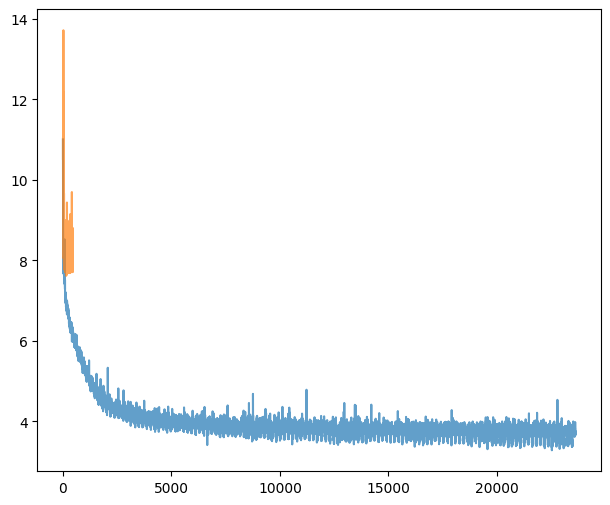

In [2]:
# parse and visualize the logfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

def gen_points(filename):
    # load the log file
    with open(filename, "r") as f:
        lines = f.readlines()

    # parse the individual lines, group by stream (train,val,hella)
    streams = {}
    idx = 0
    for line in lines:
        idx += 1
        tokens = line.strip().split()
        if tokens[0] != "@":
            continue
        step, stream, val = tokens[1], tokens[2], tokens[3].replace(',','')
        if stream not in streams:
            streams[stream] = {}
        streams[stream][int(step)] = float(val)

    # convert each stream from {step: val} to (steps[], vals[])
    # so it's easier for plotting
    streams_xy = {}
    for k, v in streams.items():
        # get all (step, val) items, sort them
        xy = sorted(list(v.items()))
        # unpack the list of tuples to tuple of lists
        streams_xy[k] = list(zip(*xy))
    return streams_xy

streams_xy_0 = gen_points("log-ben/0-base-log.txt")
streams_xy_test = gen_points("log-ben/log.txt")

# create figure
plt.figure(figsize=(16, 6))


# Panel 1: losses: both train and val
plt.subplot(121)

xs, ys = streams_xy_0["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) train loss base', alpha=0.7)
print("Min Train Loss (base):", min(ys))


xs, ys = streams_xy_test["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) train loss test', alpha=0.7)
print("Min Train Loss (tests):", min(ys))



# xs, ys = streams_xy_test["val"] # validation loss
# plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss test')
# xs, ys = streams_xy_0["val"] # validation loss
# plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss base')
# # horizontal line at GPT-2 baseline
# if loss_baseline is not None:
#     plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
# plt.xlabel("steps")
# plt.ylabel("loss")
# plt.yscale('log')
# plt.ylim(top=8.0)
# plt.xlim(right=30000)
# plt.legend()
# plt.title("Loss")
# print("Min Validation Loss:", min(ys))

# # Panel 2: HellaSwag eval
# plt.subplot(122)
# xs, ys = streams_xy_test["hellaswag"] # HellaSwag eval
# ys = np.array(ys)
# plt.plot(xs, ys, label=f"nanogpt ({sz})")
# # horizontal line at GPT-2 baseline
# if hella2_baseline:
#     plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
# if hella3_baseline:
#     plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
# plt.xlabel("steps")
# plt.ylabel("accuracy")
# plt.legend()
# plt.title("HellaSwag eval")
# print("Max Hellaswag eval:", max(ys))